In [ ]:
#| hide
!pip install -Uqq nixtla

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Improve Forecast Accuracy with TimeGPT

In this notebook, we demonstrate how to use TimeGPT for forecasting and explore three common strategies to enhance forecast accuracy. We use the hourly electricity price data from Germany as our example dataset. Before running the notebook, please initiate a NixtlaClient object with your api_key in the code snippet below.

### Result Summary

| Steps | Description                  | MAE  | MAE Improvement (%) | RMSE  | RMSE Improvement (%) |
|-------|------------------------------|------|---------------------|-------|----------------------|
| 0     | Zero-Shot TimeGPT            | 18.5 | N/A                 | 20.0  | N/A                  |
| 1     | Add Fine-Tuning Steps        | 11.5 | 38%                 | 12.6  | 37%                  |
| 2     | Adjust Fine-Tuning Loss      | 9.6  | 48%                 | 11.0  | 45%                  |
| 3     | Fine-tune more parameters    | 9.0  | 51%                 | 11.3  | 44%                  |
| 4     | Add Exogenous Variables      | 4.6  | 75%                 | 6.4   | 68%                  |
| 5     | Switch to Long-Horizon Model | 6.4  | 65%                 | 7.7   | 62%                  |


In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/tutorials/22_how_to_improve_forecast_accuracy')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/22_how_to_improve_forecast_accuracy.ipynb)

First, we install and import the required packages, initialize the Nixtla client and create a function for calculating evaluation metrics.

In [ ]:
import numpy as np
import pandas as pd

from utilsforecast.evaluation import evaluate
from utilsforecast.plotting import plot_series
from utilsforecast.losses import mae, rmse
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # api_key = 'my_api_key_provided_by_nixtla'
)

## 1. load in dataset
In this notebook, we use hourly electricity prices as our example dataset, which consists of 5 time series, each with approximately 1700 data points. For demonstration purposes, we focus on the German electricity price series. The time series is split, with the last 48 steps (2 days) set aside as the test set.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-with-ex-vars.csv')
df['ds'] = pd.to_datetime(df['ds'])
df_sub = df.query('unique_id == "DE"')

In [ ]:
df_train = df_sub.query('ds < "2017-12-29"')
df_test = df_sub.query('ds >= "2017-12-29"')
df_train.shape, df_test.shape

((1632, 12), (48, 12))

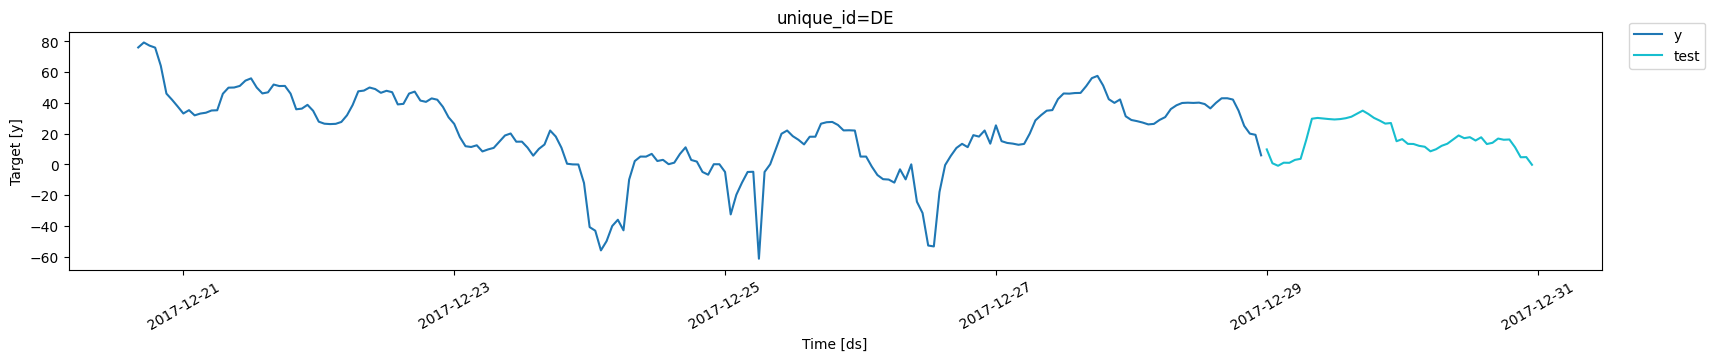

In [ ]:
plot_series(df_train[['unique_id','ds','y']][-200:], forecasts_df= df_test[['unique_id','ds','y']].rename(columns={'y': 'test'}))

## 2. Benchmark Forecasting using TimeGPT
We used TimeGPT to generate a zero-shot forecast for the time series. As illustrated in the plot, TimeGPT captures the overall trend reasonably well, but it falls short in modeling the short-term fluctuations and cyclical patterns present in the actual data. During the test period, the model achieved a Mean Absolute Error (MAE) of 18.5 and a Root Mean Square Error (RMSE) of 20. This forecast serves as a baseline for further comparison and optimization.

In [ ]:
fcst_timegpt = nixtla_client.forecast(df = df_train[['unique_id','ds','y']],
                                      h=2*24,
                                      target_col = 'y',
                                      level = [90, 95])

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [ ]:
metrics = [mae, rmse]

In [ ]:
evaluation = evaluate(
    fcst_timegpt.merge(df_test, on=['unique_id', 'ds']),
    metrics=metrics,
    models=['TimeGPT']
)
evaluation

,unique_id,metric,TimeGPT
0,DE,mae,18.519004
1,DE,rmse,20.037751


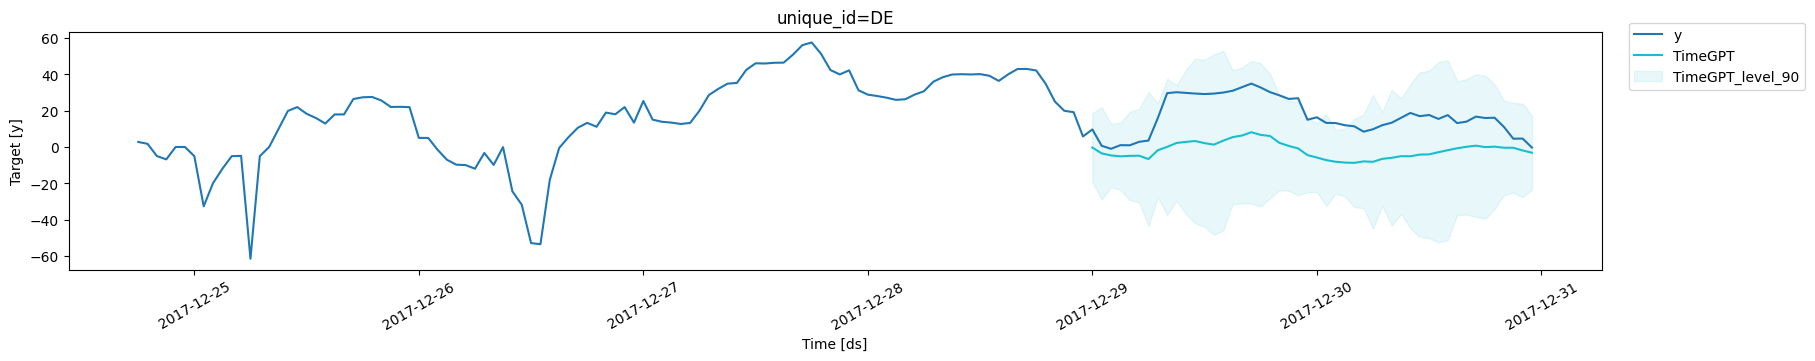

In [ ]:
plot_series(df_sub.iloc[-150:], forecasts_df= fcst_timegpt, level = [90])

## 3. Methods to Improve Forecast Accuracy
### 3a. Add Finetune Steps
The first approach to enhance forecast accuracy is to increase the number of fine-tuning steps. The fine-tuning process adjusts the weights within the TimeGPT model, allowing it to better fit your customized data. This adjustment enables TimeGPT to learn the nuances of your time series more effectively, leading to more accurate forecasts. With 30 fine-tuning steps, we observe that the MAE decreases to 11.5 and the RMSE drops to 12.6.

In [ ]:
fcst_finetune_df = nixtla_client.forecast(df=df_train[['unique_id', 'ds', 'y']],
                                          h=24*2,
                                          finetune_steps = 30,
                                          level=[90, 95])

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [ ]:
evaluation = evaluate(
    fcst_finetune_df.merge(df_test, on=['unique_id', 'ds']),
    metrics=metrics,
    models=['TimeGPT']
)
evaluation

,unique_id,metric,TimeGPT
0,DE,mae,11.458185
1,DE,rmse,12.642999


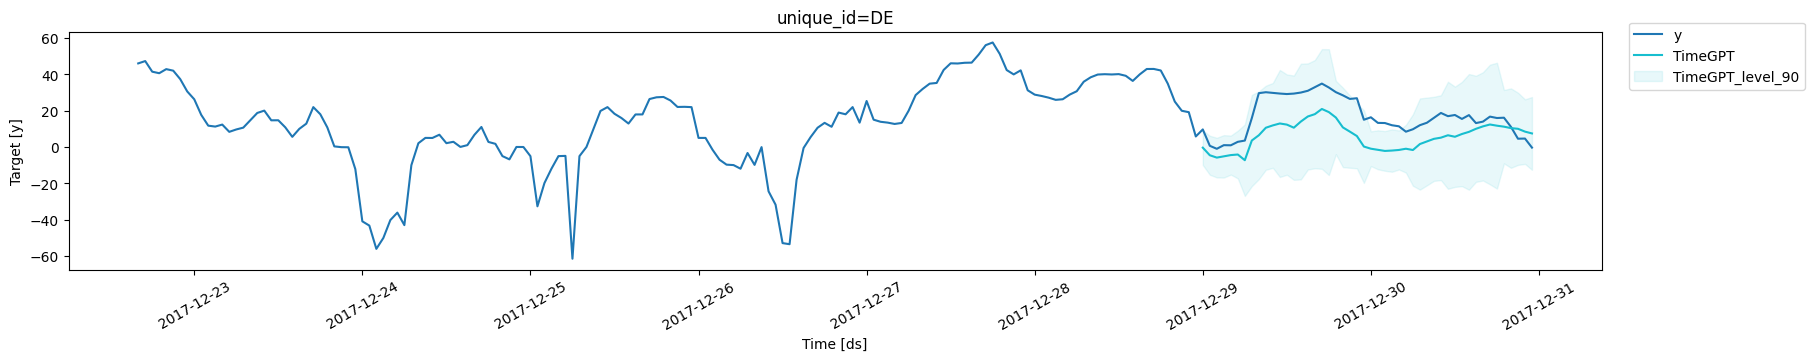

In [ ]:
plot_series(df_sub[-200:], forecasts_df= fcst_finetune_df, level = [90])

### 3b. Finetune with Different Loss Function
The second way to further reduce forecast error is to adjust the loss function used during fine-tuning. You can specify your customized loss function using the `finetune_loss` parameter. By modifying the loss function, we observe that the MAE decreases to 9.6 and the RMSE reduces to 11.0.

In [ ]:
fcst_finetune_mae_df = nixtla_client.forecast(df=df_train[['unique_id', 'ds', 'y']],
                                          h=24*2,
                                          finetune_steps = 30,
                                          finetune_loss = 'mae',
                                          level=[90, 95])

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [ ]:
evaluation = evaluate(
    fcst_finetune_mae_df.merge(df_test, on=['unique_id', 'ds']),
    metrics=metrics,
    models=['TimeGPT']
)
evaluation

,unique_id,metric,TimeGPT
0,DE,mae,9.640649
1,DE,rmse,10.956003


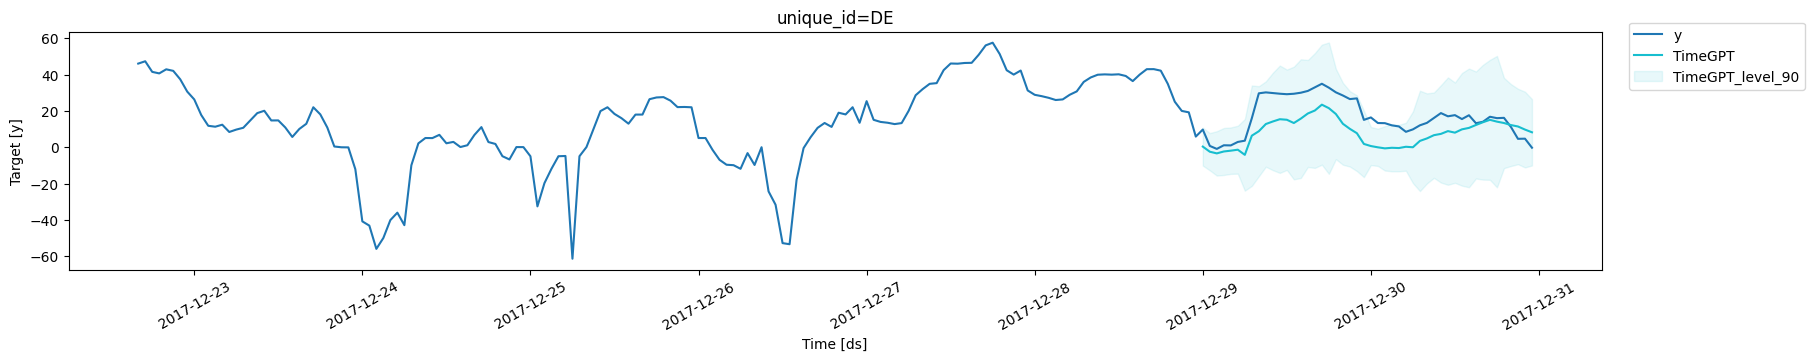

In [ ]:
plot_series(df_sub[-200:], forecasts_df= fcst_finetune_mae_df, level = [90])

### 3c. Adjust the number of parameters being fine-tuned

Using the `finetune_depth` parameter, we can control the number of parameters that get fine-tuned. By default, `finetune_depth=1`, meaning that few parameters are tuned. We can set it to any value from 1 to 5, where 5 means that we fine-tune all of the parameters of the model.

In [ ]:
fcst_finetune_depth_df = nixtla_client.forecast(df=df_train[['unique_id', 'ds', 'y']],
                                                h=24*2,
                                                finetune_steps = 30,
                                                finetune_depth=2,
                                                finetune_loss = 'mae',
                                                level=[90, 95])

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [ ]:
evaluation = evaluate(
    fcst_finetune_depth_df.merge(df_test, on=['unique_id', 'ds']),
    metrics=metrics,
    models=['TimeGPT']
)
evaluation

,unique_id,metric,TimeGPT
0,DE,mae,9.002193
1,DE,rmse,11.348207


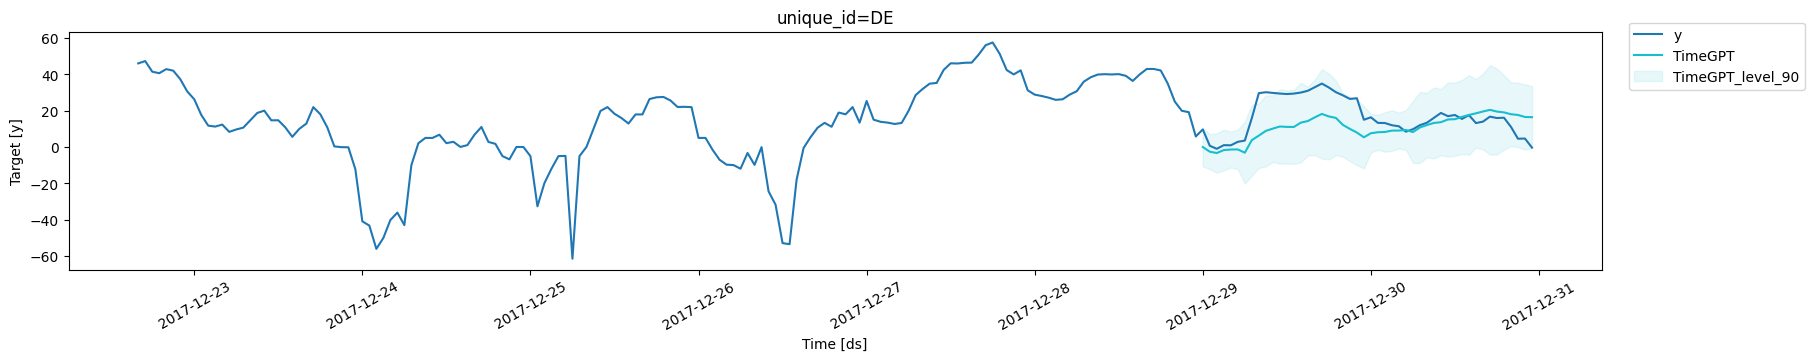

In [ ]:
plot_series(df_sub[-200:], forecasts_df= fcst_finetune_depth_df, level = [90])

### 3d. Forecast with Exogenous Variables
Exogenous variables are external factors or predictors that are not part of the target time series but can influence its behavior. Incorporating these variables can provide the model with additional context, improving its ability to understand complex relationships and patterns in the data.

To use exogenous variables in TimeGPT, pair each point in your input time series with the corresponding external data. If you have future values available for these variables during the forecast period, include them using the X_df parameter. Otherwise, you can omit this parameter and still see improvements using only historical values. In the example below, we incorporate 8 historical exogenous variables along with their values during the test period, which reduces the MAE and RMSE to 4.6 and 6.4, respectively.

In [ ]:
df_train.head()

,unique_id,ds,y,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
1680,DE,2017-10-22 00:00:00,19.10,16972.75,15778.92975,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1681,DE,2017-10-22 01:00:00,19.03,16254.50,16664.20950,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1682,DE,2017-10-22 02:00:00,16.90,15940.25,17728.74950,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1683,DE,2017-10-22 03:00:00,12.98,15959.50,18578.13850,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1684,DE,2017-10-22 04:00:00,9.24,16071.50,19389.16750,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
future_ex_vars_df = df_test.drop(columns = ['y'])
future_ex_vars_df.head()

,unique_id,ds,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
3312,DE,2017-12-29 00:00:00,17347.00,24577.92650,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3313,DE,2017-12-29 01:00:00,16587.25,24554.31950,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3314,DE,2017-12-29 02:00:00,16396.00,24651.45475,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3315,DE,2017-12-29 03:00:00,16481.25,24666.04300,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3316,DE,2017-12-29 04:00:00,16827.75,24403.33350,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
fcst_ex_vars_df = nixtla_client.forecast(df=df_train,
                                         X_df=future_ex_vars_df,
                                         h=24*2,
                                         level=[90, 95])

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['Exogenous1', 'Exogenous2', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [ ]:
evaluation = evaluate(
    fcst_ex_vars_df.merge(df_test, on=['unique_id', 'ds']),
    metrics=metrics,
    models=['TimeGPT']
)
evaluation

,unique_id,metric,TimeGPT
0,DE,mae,4.602594
1,DE,rmse,6.358831


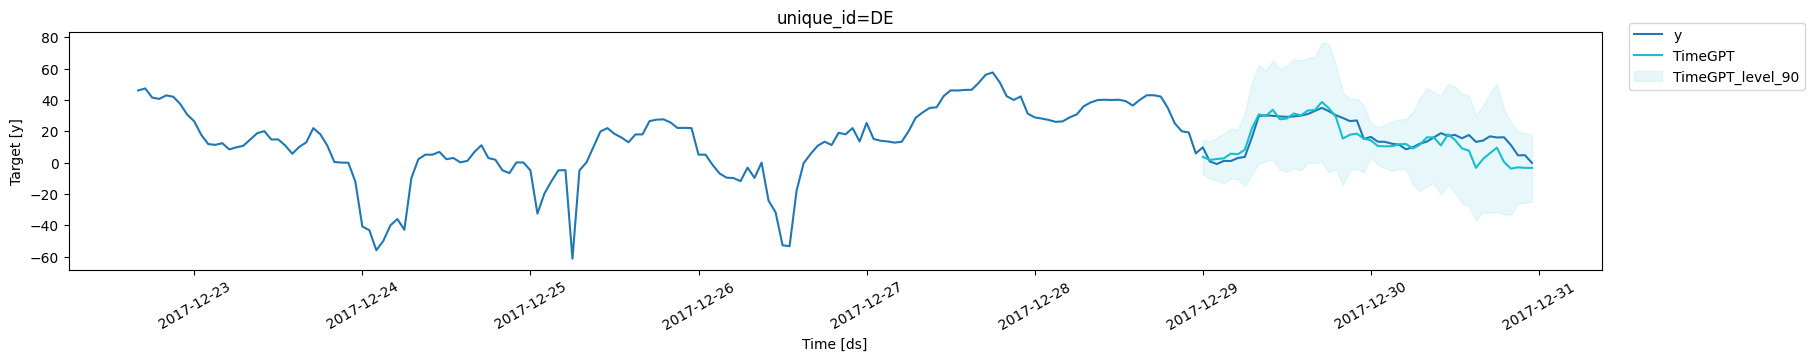

In [ ]:
plot_series(df_sub[-200:], forecasts_df= fcst_ex_vars_df, level = [90])

### 3d. TimeGPT for Long Horizon Forecasting
When the forecasting period is too long, the predicted results may not be as accurate. TimeGPT performs best with forecast periods that are shorter than one complete cycle of the time series. For longer forecast periods, switching to the timegpt-1-long-horizon model can yield better results. You can specify this model by using the model parameter.

In the electricity price time series used here, one cycle is 24 steps (representing one day). Since we’re forecasting two days (48 steps) into the future, using timegpt-1-long-horizon significantly improves the forecasting accuracy, reducing the MAE to 6.4 and RMSE to 7.7.

In [ ]:
fcst_long_df = nixtla_client.forecast(df=df_train[['unique_id', 'ds', 'y']],
                                          h=24*2,
                                          model = 'timegpt-1-long-horizon',
                                          level=[90, 95])

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [ ]:
evaluation = evaluate(
    fcst_long_df.merge(df_test, on=['unique_id', 'ds']),
    metrics=metrics,
    models=['TimeGPT']
)
evaluation

,unique_id,metric,TimeGPT
0,DE,mae,6.365540
1,DE,rmse,7.738188


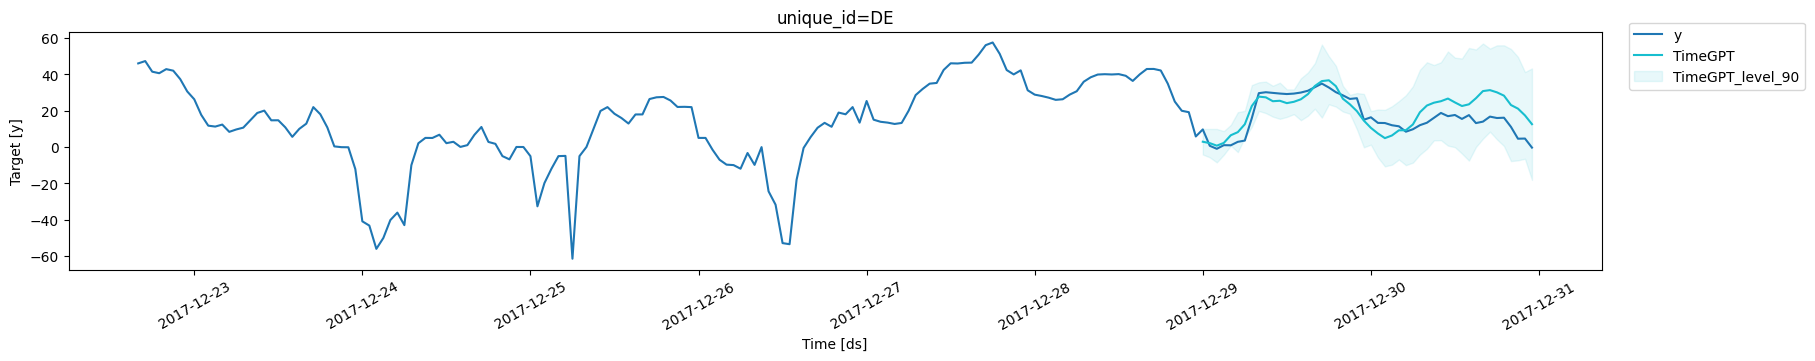

In [ ]:
plot_series(df_sub[-200:], forecasts_df= fcst_long_df, level = [90])

## 4. Conclusion and Next Steps

In this notebook, we demonstrated four effective strategies for enhancing forecast accuracy with TimeGPT:

1. **Increasing the number of fine-tuning steps.**
2. **Adjusting the fine-tuning loss function.**
3. **Incorporating exogenous variables.**
4. **Switching to the long-horizon model for extended forecasting periods.**

We encourage you to experiment with these hyperparameters to identify the optimal settings that best suit your specific needs. Additionally, please refer to our documentation for further features, such as **model explainability** and more.

In the examples provided, after applying these methods, we observed significant improvements in forecast accuracy metrics, as summarized below.

### Result Summary

| Steps | Description                  | MAE  | MAE Improvement (%) | RMSE  | RMSE Improvement (%) |
|-------|------------------------------|------|---------------------|-------|----------------------|
| 0     | Zero-Shot TimeGPT            | 18.5 | N/A                 | 20.0  | N/A                  |
| 1     | Add Fine-Tuning Steps        | 11.5 | 38%                 | 12.6  | 37%                  |
| 2     | Adjust Fine-Tuning Loss      | 9.6  | 48%                 | 11.0  | 45%                  |
| 3     | Fine-tune more parameters    | 9.0  | 51%                 | 11.3  | 44%                  |
| 4     | Add Exogenous Variables      | 4.6  | 75%                 | 6.4   | 68%                  |
| 5     | Switch to Long-Horizon Model | 6.4  | 65%                 | 7.7   | 62%                  |